In [9]:
# imports
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import random

In [10]:
# load world3 data as json
json_file = open("world3-03_variables.json")
w3_vars = json.loads(json_file.read())
json_file.close()

In [11]:
# convert world3 to a network
G = nx.DiGraph()
for name, val in w3_vars.items():
    G.add_node(name, var_type=val["type"])
    if val["dependencies"] is not None:
        G.add_edges_from([(dep, name) for dep in val["dependencies"]])

In [12]:
# display the loaded graph
print(f"G: {G}")
f, ax = plt.subplots(figsize=(22, 22))
nx.draw(G)

G: DiGraph with 316 nodes and 507 edges
Error in callback <function flush_figures at 0x14bfc4cc0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

# Cycle Analysis

In [ ]:
# NOTE: we might consider cycle basis, not sure it would be relevant

# Compute all cycles in world3 up to length length_bound
length_bound = 75
directed_cycles = nx.simple_cycles(G, length_bound=length_bound)
directed_cycles = list(directed_cycles)

for length 75, found 1863803 cycles
found mean=43.63671428793708, std=8.209200350268096


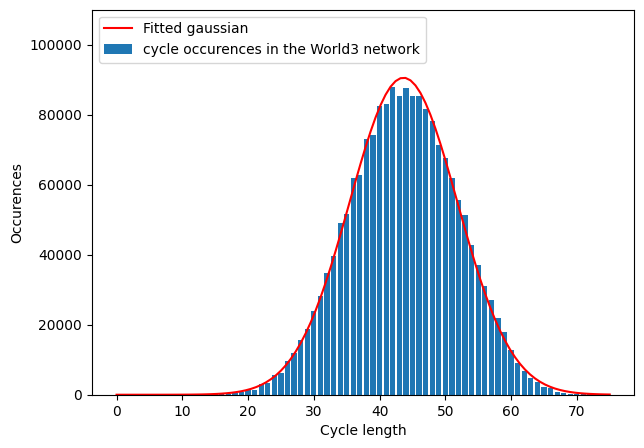

['resource_technology_change_rate', 'resource_conservation_technology']
['maturation_44_to_45', 'population_15_to_44']
['deaths_15_to_44', 'population_15_to_44']
['deaths_45_to_64', 'population_45_to_64']
['maturation_64_to_65', 'population_45_to_64']
['deaths_65_plus', 'population_65_plus']
['maturation_14_to_15', 'population_0_to_14']
['deaths_0_to_14', 'population_0_to_14']
['urban_and_industrial_land', 'land_removal_for_urban_and_industrial_use']
['arable_land', 'land_erosion_rate']
['persistent_pollution', 'persistent_pollution_assimilation_rate']
['service_capital', 'service_capital_depreciation']
['industrial_capital_depreciation', 'industrial_capital']
['persistent_pollution_technology_change_rate', 'persistent_pollution_technology']
['land_yield_technology', 'land_yield_technology_change_rate']
['land_fertility_regeneration', 'land_fertility']
['land_fertility', 'land_fertility_degredation']
['industrial_output', 'industrial_capital_investment', 'industrial_capital']
['potenti

In [ ]:
total_count = len(directed_cycles)
print(f"for length {length_bound}, found {total_count} cycles")

length_occurrences = {}
for cycle in directed_cycles:
    length = len(cycle)
    if length_occurrences.get(length) is None:
        length_occurrences[length] = 0
    length_occurrences[length] += 1

mean = 0
for length, occ in length_occurrences.items():
    mean += length * occ
mean = mean / total_count

std = 0
for length, occ in length_occurrences.items():
    std += ((length - mean) ** 2) * occ
std = (std / total_count) ** 0.5

print(f"found mean={mean}, std={std}")

x = np.linspace(0, length_bound, 100)
plt.figure(figsize=(7, 5))
plt.bar(length_occurrences.keys(), length_occurrences.values(), label="cycle occurences in the World3 network")
plt.gca().set_ylim([0, 110000])
plt.plot(x, total_count * stats.norm.pdf(x, mean, std), label='Fitted gaussian', color='red')
plt.xlabel("Cycle length")
plt.ylabel("Occurences")
plt.legend(loc='upper left', fontsize=10)
plt.savefig("figures/world3_cycle_histogram.png", dpi=300)
plt.show()


sorted_cycles = sorted(directed_cycles, key= lambda x: len(x))

print_count = 20
for cycle in sorted_cycles[:print_count]:
    print(cycle)

In [ ]:
# Perform the same analysis with a random graph
n, e = G.number_of_nodes(), G.number_of_edges()
random_samples = 10

random_directed_cycles_lengths_list = []
for i in range(random_samples):
    #generated_e = 0
    #while generated_e < e - 30 or generated_e > e - 10:
    e_r_G = nx.erdos_renyi_graph(n, e / (n * (n-1)), directed=True)
        #generated_e = e_r_G.number_of_edges()
    # cc = nx.number_strongly_connected_components(e_r_G)
    print(f"Created random erdos_renyi graph with {e_r_G.number_of_nodes()} nodes and {e_r_G.number_of_edges()} edges.")
    # print(f"It features {cc} strongly connected components")
    # print(f"By comparison, world3 features {nx.number_strongly_connected_components(G)} strongly connected components")

    # Compute the directed cycles in the random graph
    random_length_bound = 80
    random_directed_cycles = nx.simple_cycles(e_r_G, length_bound=random_length_bound)
    random_directed_cycles_lengths = [len(cycle) for cycle in random_directed_cycles]
    random_directed_cycles_lengths_list.append(random_directed_cycles_lengths)
    print(f"generated {i}th E.R graph, which contained {len(random_directed_cycles_lengths)} cycles.")

Created random erdos_renyi graph with 316 nodes and 519 edges.


KeyboardInterrupt: 

for length 80, found 1056915.3 cycles in average (std=2144625.699353249)
random_length_occurrences={10: 79, 31: 24252, 46: 269825, 48: 323108, 37: 76977, 60: 401066, 47: 295965, 53: 431509, 68: 174974, 59: 420495, 55: 448906, 42: 167993, 40: 125070, 70: 125461, 57: 443803, 61: 379049, 39: 107096, 35: 53319, 33: 36068, 41: 145683, 38: 90928, 66: 232705, 50: 374301, 58: 434645, 52: 413786, 65: 264799, 45: 242403, 44: 215667, 22: 2786, 63: 324970, 34: 44420, 32: 29767, 54: 441103, 49: 349089, 51: 397325, 56: 448236, 64: 293547, 36: 64337, 43: 189746, 21: 2171, 30: 19312, 62: 351438, 73: 69722, 72: 85343, 69: 149889, 78: 20975, 75: 44491, 77: 27419, 74: 55458, 71: 104499, 67: 204089, 76: 34765, 80: 12136, 29: 15426, 26: 7654, 23: 3629, 25: 5903, 28: 12413, 24: 4678, 27: 9758, 12: 149, 19: 1267, 11: 95, 20: 1662, 17: 717, 16: 527, 18: 923, 15: 419, 14: 273, 13: 216, 79: 16244, 9: 73, 8: 43, 6: 28, 5: 24, 7: 40, 4: 13, 3: 9, 2: 5}
random_length_occurrences={10: 7.9, 31: 2425.2, 46: 26982.5, 

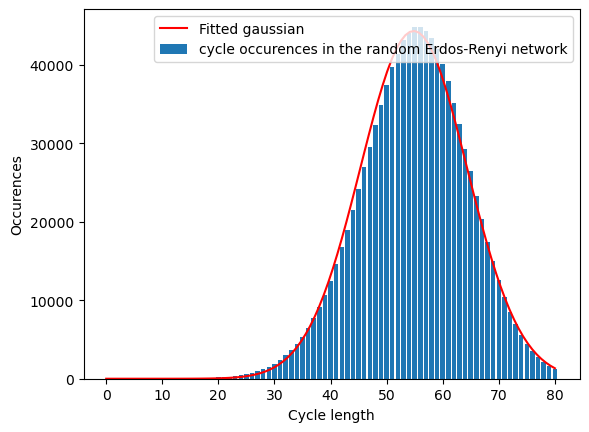

In [ ]:
random_directed_cycles_count_list = np.array([len(cycle_lengths) for cycle_lengths in random_directed_cycles_lengths_list])

length_bound=80
random_mean_count = random_directed_cycles_count_list.mean()
random_std_count = random_directed_cycles_count_list.std()
print(f"for length {length_bound}, found {random_mean_count} cycles in average (std={random_std_count})")


random_length_occurrences = {}
for random_directed_cycles_lengths in random_directed_cycles_lengths_list:
    for cycle_length in random_directed_cycles_lengths:
        if random_length_occurrences.get(cycle_length) is None:
            random_length_occurrences[cycle_length] = 0
        random_length_occurrences[cycle_length] += 1
print(f"random_length_occurrences={random_length_occurrences}")
for length, occ in random_length_occurrences.items():
    random_length_occurrences[length] = occ / random_samples
print(f"random_length_occurrences={random_length_occurrences}")

random_mean = 0
for length, occ in random_length_occurrences.items():
    random_mean += length * occ
random_mean = random_mean / random_mean_count

random_std = 0
for length, occ in random_length_occurrences.items():
    random_std += ((length - random_mean) ** 2) * occ
random_std = (random_std / random_mean_count) ** 0.5

print(f"found mean={random_mean}, std={random_std}")

plt.bar(random_length_occurrences.keys(), random_length_occurrences.values(), label="cycle occurences in the random Erdos-Renyi network")
x = np.linspace(0, length_bound, 100)
plt.plot(x, random_mean_count * stats.norm.pdf(x, random_mean, random_std), label='Fitted gaussian', color='red')
plt.xlabel("Cycle length")
plt.ylabel("Occurences")
plt.legend()
plt.show()

# Analysis
Similar mean and npstd, but way more cycles overall. This is consistent across runs, however I would need to make several runs (at least 10) to perform statistics (mean of means/stds, and means of total counts).
We can clearly see that in all cases it very closely follows the gaussian distribution.
The conclusion would be that the world3 model tends to have many more cycles than expected at random.

In [ ]:
# Code taken from my (Ismaïl's) Assignment 2 submission 
def rewiring(G, iterations=10000):
    # select 2 edges at random
    edges = list(G.edges())
    m = len(edges)

    for i in range(iterations):
        e1_idx = random.randint(0, m-1)
        e2_idx = e1_idx
        # ensure different sampled edges
        while e2_idx == e1_idx:
            e2_idx = random.randint(0, m-1) 
        e1 = edges[e1_idx] # e1 = (A,B)
        e2 = edges[e2_idx] # e2 = (C,D)
        A, B = e1
        C, D = e2
        new_e1 = (A, D)
        new_e2 = (C, B)
    
        # we create a multi-edge if (A,D) or (C,B) is already in E
        if G.has_edge(A, D) or G.has_edge(C, B):
            continue

        # we create a self-loop if A==D or C==B
        if A==D or C==B:
            continue

        # make the replacement
        edges[e1_idx] = new_e1
        edges[e2_idx] = new_e2

    return nx.from_edgelist(edges, create_using=nx.DiGraph)

In [ ]:
rewired_directed_cycles_lengths_list = []
for i in range(random_samples):
    rewired_G = rewiring(G)

    # Compute the directed cycles in the rewired graph
    rewired_length_bound = 80
    rewired_directed_cycles = nx.simple_cycles(rewired_G, length_bound=rewired_length_bound)
    rewired_directed_cycles_lenghts = [len(cycle) for cycle in rewired_directed_cycles]
    rewired_directed_cycles_lengths_list.append(rewired_directed_cycles_lenghts)
    print(f"performed {i}th rewiring cycling fetch")

performed 0th rewiring cycling fetch
performed 1th rewiring cycling fetch
performed 2th rewiring cycling fetch
performed 3th rewiring cycling fetch
performed 4th rewiring cycling fetch
performed 5th rewiring cycling fetch
performed 6th rewiring cycling fetch
performed 7th rewiring cycling fetch
performed 8th rewiring cycling fetch
performed 9th rewiring cycling fetch


rewired_counts_list=[926911 815837  81640  20263 941808   4416   3738  61627  22059  55206]
for length 80, found 293350.5 cycles in average (std=395683.27035224775)
rewired_length_occurrences={26: 13733, 32: 42020, 50: 114373, 48: 119898, 45: 119475, 54: 91612, 42: 109241, 49: 117915, 46: 121139, 24: 8601, 25: 11003, 29: 25431, 51: 110275, 34: 55519, 19: 2247, 30: 30322, 43: 113858, 52: 104599, 40: 97884, 47: 121672, 44: 116952, 22: 5256, 23: 6687, 27: 16919, 37: 77105, 35: 62705, 53: 98202, 57: 68259, 28: 20768, 33: 48389, 39: 91518, 63: 24843, 61: 37267, 58: 60304, 67: 8506, 55: 84264, 62: 30675, 59: 52297, 38: 84679, 64: 19709, 56: 76422, 31: 35796, 36: 69677, 41: 103661, 18: 1668, 21: 4028, 66: 11444, 70: 2879, 65: 15217, 60: 44391, 20: 3027, 17: 1242, 71: 1857, 68: 6113, 69: 4307, 74: 370, 16: 874, 15: 618, 72: 1078, 14: 489, 73: 640, 76: 96, 77: 48, 75: 191, 78: 31, 12: 238, 13: 348, 11: 183, 79: 10, 7: 49, 8: 54, 9: 84, 80: 8, 10: 113, 5: 33, 4: 26, 6: 41, 3: 21, 2: 12}
rewired_

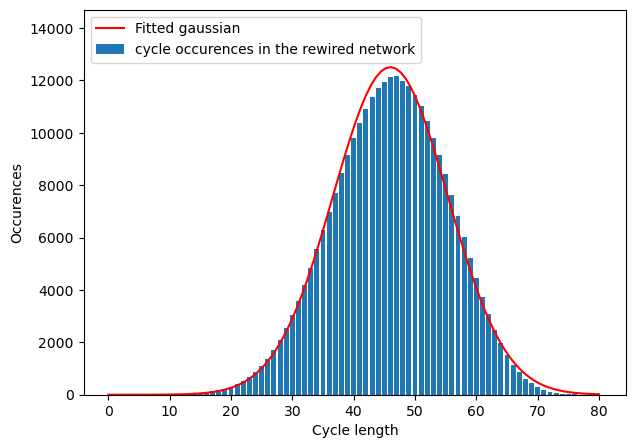

In [ ]:
rewired_directed_cycles_count_list = np.array([len(cycle_lengths) for cycle_lengths in rewired_directed_cycles_lengths_list])
print(f"rewired_counts_list={rewired_directed_cycles_count_list}")

length_bound=80
rewired_mean_count = rewired_directed_cycles_count_list.mean()
rewired_std_count = rewired_directed_cycles_count_list.std()
print(f"for length {length_bound}, found {rewired_mean_count} cycles in average (std={rewired_std_count})")

rewired_length_occurrences = {}
for rewired_directed_cycles_lengths in rewired_directed_cycles_lengths_list:
    for cycle_length in rewired_directed_cycles_lengths:
        if rewired_length_occurrences.get(cycle_length) is None:
            rewired_length_occurrences[cycle_length] = 0
        rewired_length_occurrences[cycle_length] += 1
print(f"rewired_length_occurrences={rewired_length_occurrences}")
for length, occ in rewired_length_occurrences.items():
    rewired_length_occurrences[length] = occ / random_samples
print(f"rewired_length_occurrences={rewired_length_occurrences}")

rewired_mean = 0
for length, occ in rewired_length_occurrences.items():
    rewired_mean += length * occ
rewired_mean = rewired_mean / rewired_mean_count

rewired_std = 0
for length, occ in rewired_length_occurrences.items():
    rewired_std += ((length - rewired_mean) ** 2) * occ
rewired_std = (rewired_std / rewired_mean_count) ** 0.5

print(f"found mean={rewired_mean}, std={rewired_std}")

x = np.linspace(0, length_bound, 100)
plt.figure(figsize=(7, 5))
plt.bar(rewired_length_occurrences.keys(), rewired_length_occurrences.values(), label="cycle occurences in the rewired network")
plt.gca().set_ylim([0, 14700])
plt.plot(x, rewired_mean_count * stats.norm.pdf(x, rewired_mean, rewired_std), label='Fitted gaussian', color='red')
plt.xlabel("Cycle length")
plt.ylabel("Occurences")
plt.legend(loc='upper left', fontsize=10)
plt.savefig("figures/rewired_cycle_histogram.png", dpi=300)
plt.show()

# Analysis
Same, we need to perform statistics, but the conclusion go in the same way: world3 is specifically heavily cycled, with cycles of roughly expected length distribution.

In [13]:
# Try to find, given importance variables, cycles in which the most of these variables appear
important_variables = ['industrial_ouput', 'resource_use_intensity']

# only consider relatively short cycles for now
# rationale for that: short cycles are likely to correspond to stronger dependencies, are easier to analyze and design policy about.
short_cycle_threshold = 50
short_cycles = [cycle for cycle in directed_cycles if len(cycle) <= short_cycle_threshold]

def intersection(a, b): 
    return list(set(a) & set(b))

short_cycles_with_matching_count = [(cycle, len(intersection(cycle, important_variables))) for cycle in short_cycles]
sorted_short_cycles_with_matching_count = sorted(short_cycles_with_matching_count, key= lambda x: (x[1], -len(x[0])), reverse=True)

sorted_short_cycles_with_matching_count[:10]

[(['resource_technology_change_rate', 'resource_conservation_technology'], 0),
 (['maturation_44_to_45', 'population_15_to_44'], 0),
 (['deaths_15_to_44', 'population_15_to_44'], 0),
 (['deaths_45_to_64', 'population_45_to_64'], 0),
 (['maturation_64_to_65', 'population_45_to_64'], 0),
 (['deaths_65_plus', 'population_65_plus'], 0),
 (['maturation_14_to_15', 'population_0_to_14'], 0),
 (['deaths_0_to_14', 'population_0_to_14'], 0),
 (['urban_and_industrial_land', 'land_removal_for_urban_and_industrial_use'],
  0),
 (['arable_land', 'land_erosion_rate'], 0)]